<a href="https://colab.research.google.com/github/muhammad-usama-aleem/Roboflow-Object-Detection-Notebooks/blob/main/dino-gpt4v-autodistill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# DINO-GPT4-V: Use GPT-4V in a Two-Stage Detection Model

[Autodistill](https://github.com/autodistill/autodistill) uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

With Autodistill, you can use DINO-GPT4-V, a model that uses GPT-4V and Grounding DINO to label data for use in training fine-tuned object detection models.

[Read the guide that accompanies this blog post](https://blog.roboflow.com/dino-gpt-4v/).

By the end of this guide, we will label car brands in images. Here is an example:

<div>
<img src="https://blog.roboflow.com/content/images/2023/11/Screenshot-2023-11-07-at-12.55.18.png" width="500"/>
</div>

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Preparing a dataset
- Label a dataset with DINO-GPT4-V
- Train a YOLOv8 model with the labeled dataset
- (Optional): Deploy the model with Roboflow Inference

Let's begin!


## ⚡ Before you start

Let's make sure that we have access to a GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Dec 21 17:55:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill and Dependencies

Run the following code cell to install the dependencies required for this project:

In [2]:
!pip install autodistill autodistill-grounding-dino autodistill-gpt-4v -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00


To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 🖼️ Image dataset preperation

All you need to have is a folder of images that you want to automatically annotate, and use for target model training, to get started.

In [4]:
!mkdir {HOME}/images

## Download Images

Below, we provide three methods of retrieving images for use with Autodistill:

1. Upload images into Colab (exclusive to Colab);
2. Download a dataset with images from Roboflow, and;
3. Download a raw video and split it up into images.

For this guide, we will use a zipped dataset of raw images and upload it into Colab, but instructions for all options are provided below.

### Upload images into Colab

We have an example dataset of vehicles in a parking lot that we will use for this tutorial. You can download the dataset [here](https://media.roboflow.com/dino-gpt-4v-example.zip). You can also zip up a folder of your own images.

Open the file browser from the left sidebar of Colab and upload the ZIP file. Uncomment the command below to unzip the folder, replacing `dataset.zip` with the name of the dataset with which you are working:

In [ ]:
# !unzip dataset.zip

### Download Images from Roboflow

You can download datasets from Roboflow using the below lines of code. You can download datasets associated with your account, or any of the 200,000+ public datasets on [Roboflow Universe](https://universe.roboflow.com/). To download a dataset from Roboflow, you will need a [free Roboflow account](https://app.roboflow.com).

You need to paste in a URL to a full model, like so:

```
https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16
```

To find a model URL, go to a dataset page on Universe (i.e. the [TACO dataset](https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/)), then click "Model" in the sidebar to view the latest model version. Copy the page URL, then paste it into the `download_dataset()` function below.

![Universe model link](https://media.roboflow.com/universe_deploy_tab.png)

Uncomment the lines of code below to use the Roboflow dataset upload.

In [ ]:
# import roboflow

# roboflow.login()

# dataset = roboflow.download_dataset(dataset_url="https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16", model_format="yolov8")

Once you have downloaded your dataset, move all of the images from the `train` set in your downloaded dataset into the `images/` directory we created earlier:

In [ ]:
# %mv {HOME}/<dataset-name>/train/* {HOME}/images

Now we are ready to start using Autodistill!

### Download raw videos

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

In [5]:
!mkdir {HOME}/videos
%cd {HOME}/videos

# download zip file containing videos
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt" -O milk.zip && rm -rf /tmp/cookies.txt

# unzip videos
!unzip milk.zip

/content/videos
--2023-12-21 17:56:57--  https://docs.google.com/uc?export=download&confirm=t&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt
Resolving docs.google.com (docs.google.com)... 173.194.210.139, 173.194.210.101, 173.194.210.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.210.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ojsh23qj0cjp8p4mkl7cd5mp7ps2rd7t/1703181375000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=6f23da38-3af9-4831-8c28-8ea31db1e0bc [following]
--2023-12-21 17:56:57--  https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ojsh23qj0cjp8p4mkl7cd5mp7ps2rd7t/1703181375000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=6f23da38-3af9-4831-8c28-8ea31db1e0bc
Resolving doc-08-ag-docs.googleusercontent.com (doc-08-ag-docs.googleusercontent.com)

### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [6]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 18

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [7]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/6 [00:00<?, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [8]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 72


**NOTE:** We can also plot sample of our image dataset.

In [9]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

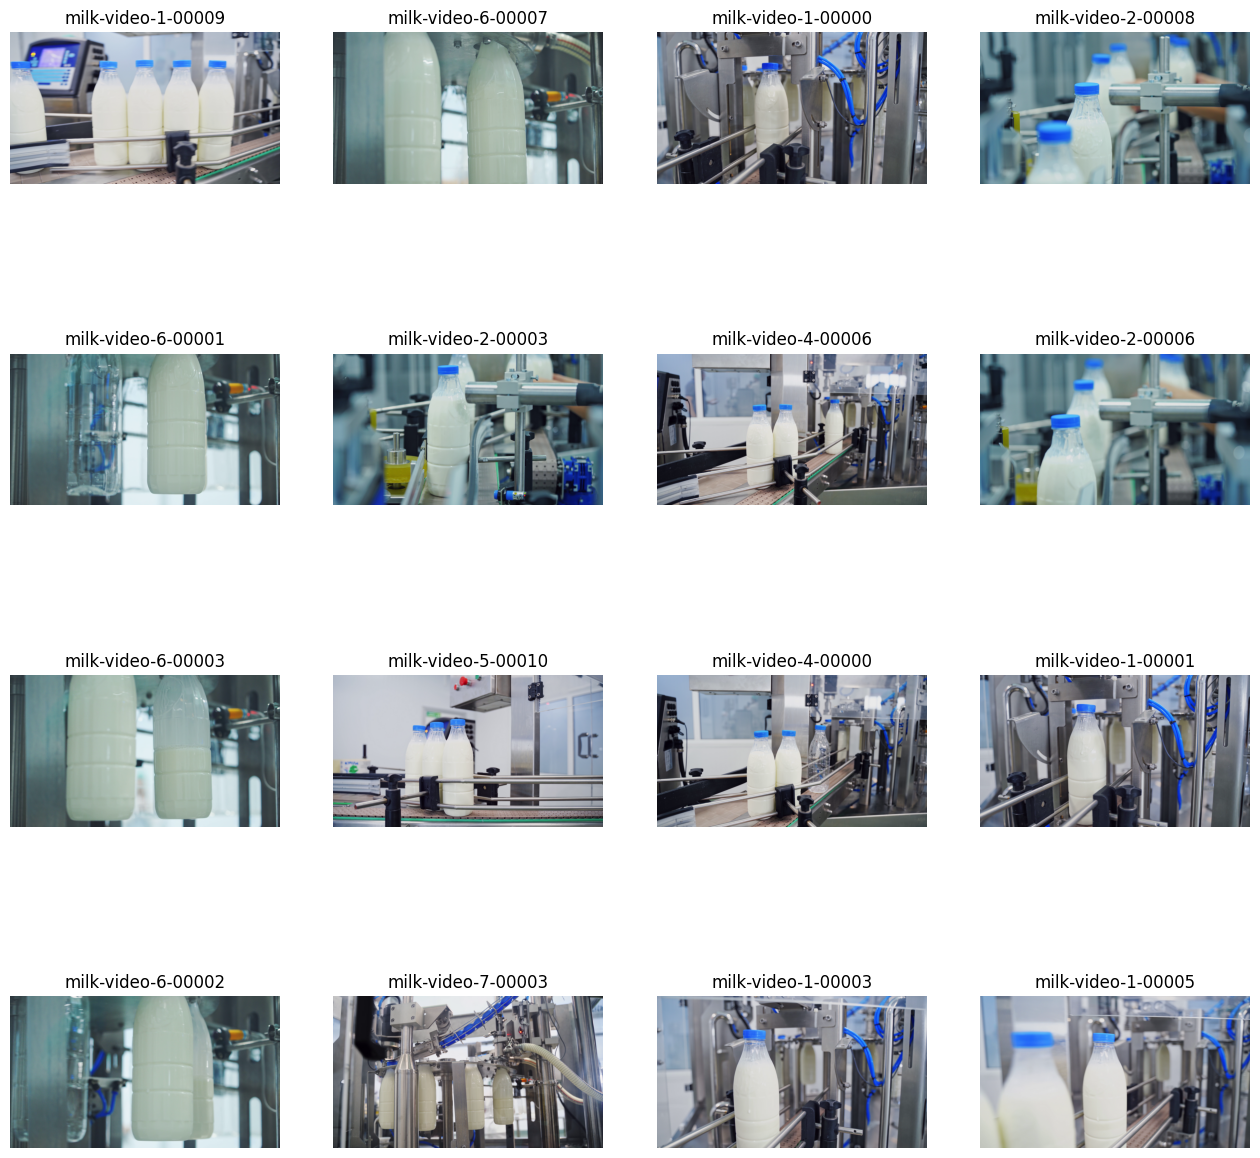

In [10]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel Dataset

DINO-GP4V is a combination of two models:

- Grounding DINO, which detects objects, and;
- GPT-4V, which can classify objects and provide specific information about an object.

In this example, we will detect car brands. Grounding DINO can detect cars but doesn't know about car brands. GPT-4V can't detect objects accurately, but can classify objects. With Autodistill, we can detect cars with Grounding DINO, then pass each car through GPT-4V for classification.

We need to define two ontologies, which refer to what we want to detect and what we want to classify. In this example, we want to detect cars and classify car brands.

What you detect should be a common object, then GPT-4V can refine the results.

In [ ]:
from autodistill_gpt_4v import GPT4V
from autodistill.detection import CaptionOntology
from autodistill_grounding_dino import GroundingDINO
from autodistill.utils import plot

from autodistill.core.custom_detection_model import CustomDetectionModel
import cv2

classes = ["mercedes", "toyota"]

DINOGPT = CustomDetectionModel(
    detection_model=GroundingDINO(
        CaptionOntology({"car": "car"})
    ),
    classification_model=GPT4V(
        CaptionOntology({k: k for k in classes}),
    api_key = "YOUR_OPENAI_API_KEY"
    )
)

IMAGE = "mercedes.jpeg"

results = DINOGPT.predict(IMAGE)

plot(
    image=cv2.imread(IMAGE),
    detections=results,
    classes=classes
)

Above, replace:

- `YOUR_OPENAI_API_KEY` with your OpenAI API key. You will need this API key to use GPT-4V.
- `IMAGE` with the path to an image.
-

`classes` is the list of classes you want to use in classification.

When you run the code, an image will be labeled. You can use the code above for testing DINO-GPT-4V on images in your dataset. When you are ready, run the code cell below to label your dataset:

In [ ]:
DINOGPT.label(f"{HOME}/images", extension=".jpeg")

Above, replace `.jpeg` with the file extension used by images in your dataset.

### Display dataset sample

Run the code cells below to create a dataset, which can then be saved, and to visualize your dataset.

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

132

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train a Model

A Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

In [ ]:
!ls {HOME}/runs/detect/train/

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

# 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.